In [ ]:
# Install required libraries
!pip install -q transformers albumentations opencv-python tqdm
!pip install torchmetrics


from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassJaccardIndex
from transformers import SegformerForSemanticSegmentation
from torch.optim.lr_scheduler import ReduceLROnPlateau


import random


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Global variables for image size & training parameters
IMG_HEIGHT = 512   # Change as needed, depending on your dataset resolution
IMG_WIDTH = 512
BATCH_SIZE = 4     # Adjust depending on Colab free tier memory
NUM_EPOCHS = 25
LEARNING_RATE = 1e-4

# Define label mappings (modify if you have more classes)
id2label = {0: "background", 1: "road"}
label2id = {"background": 0, "road": 1}
NUM_CLASSES = len(id2label)


Using device: cuda


In [ ]:
# Define offline augmentation pipeline
offline_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
])

def augment_and_save(images_dir, masks_dir, save_images_dir, save_masks_dir, augmentations_per_image=3):
    os.makedirs(save_images_dir, exist_ok=True)
    os.makedirs(save_masks_dir, exist_ok=True)

    image_paths = sorted(glob(os.path.join(images_dir, "*")))
    mask_paths = sorted(glob(os.path.join(masks_dir, "*")))

    for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        base_name = os.path.splitext(os.path.basename(img_path))[0]

        # Save original image and mask
        cv2.imwrite(os.path.join(save_images_dir, f"{base_name}.png"), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(save_masks_dir, f"{base_name}.png"), mask)

        for i in range(augmentations_per_image):
            augmented = offline_transform(image=image, mask=mask)
            aug_image = augmented['image']
            aug_mask = augmented['mask']

            aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(save_images_dir, f"{base_name}_aug_{i}.png"), aug_image_bgr)
            cv2.imwrite(os.path.join(save_masks_dir, f"{base_name}_aug_{i}.png"), aug_mask)


images_dir = '/content/drive/MyDrive/Road Segmentation/training/images'
masks_dir = '/content/drive/MyDrive/Road Segmentation/training/groundtruth'
save_images_dir = '/content/drive/MyDrive/Road Segmentation/training_augmented/images'
save_masks_dir = '/content/drive/MyDrive/Road Segmentation/training_augmented/groundtruth'

if not os.path.exists(save_images_dir) or len(os.listdir(save_images_dir)) == 0:
    augment_and_save(images_dir, masks_dir, save_images_dir, save_masks_dir, augmentations_per_image=10)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
#on the fly transformations
train_transform = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),  # Add some noise augmentation
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),
    ], p=0.3),  # Geometric distortions can help with road segmentation
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.3),  # Color variations
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


<ipython-input-4-70a707c65241>:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
<ipython-input-4-70a707c65241>:12: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),


In [ ]:
class RoadSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_paths = sorted(glob(os.path.join(images_dir, "*")))
        self.masks_paths = sorted(glob(os.path.join(masks_dir, "*")))
        self.transform = transform

        assert len(self.images_paths) == len(self.masks_paths), "Mismatch between images and masks count."

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.images_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask > 127, 1, 0).astype(np.uint8)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.clone().detach().long()

In [ ]:
# Update the paths to point to your augmented dataset
TRAIN_IMAGES_DIR = '/content/drive/MyDrive/Road Segmentation/training_augmented/images'
TRAIN_MASKS_DIR = '/content/drive/MyDrive/Road Segmentation/training_augmented/groundtruth'

# Create the full training dataset using augmented images and ground truth masks
full_dataset = RoadSegmentationDataset(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, transform=train_transform)

# Split the dataset into training and validation sets (e.g., 80/20 split)
from torch.utils.data import random_split

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

indices = list(range(len(full_dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 880
Number of validation samples: 220


In [ ]:
# Load the pretrained SegFormer model
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b2-finetuned-ade-512-512",  # B2 is larger than B0
    num_labels=NUM_CLASSES,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
#history dict to store metrics per epoch
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': [],
    'train_iou': [],
    'val_iou': [],
    'train_dice': [],
    'val_dice': []
}

In [ ]:
def calculate_dice_score(pred, target, num_classes=2, smooth=1e-6):
    dice_scores = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = torch.sum(pred_cls * target_cls)
        union = torch.sum(pred_cls) + torch.sum(target_cls)
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())
    return sum(dice_scores) / len(dice_scores)

# Modified train and validation functions to compute accuracy, F1, IoU, and Dice

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    acc_metric = MulticlassAccuracy(num_classes=NUM_CLASSES).to(device)
    f1_metric = MulticlassF1Score(num_classes=NUM_CLASSES).to(device)
    iou_metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES).to(device)
    dice_total = 0.0

    for images, masks in tqdm(loader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=images).logits
        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)

        # Update metrics
        acc_metric.update(preds, masks)
        f1_metric.update(preds, masks)
        iou_metric.update(preds, masks)
        dice_total += calculate_dice_score(preds, masks, NUM_CLASSES) * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = acc_metric.compute().item()
    epoch_f1 = f1_metric.compute().item()
    epoch_iou = iou_metric.compute().item()
    epoch_dice = dice_total / len(loader.dataset)
    return epoch_loss, epoch_acc, epoch_f1, epoch_iou, epoch_dice


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    acc_metric = MulticlassAccuracy(num_classes=NUM_CLASSES).to(device)
    f1_metric = MulticlassF1Score(num_classes=NUM_CLASSES).to(device)
    iou_metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES).to(device)
    dice_total = 0.0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(pixel_values=images).logits
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            acc_metric.update(preds, masks)
            f1_metric.update(preds, masks)
            iou_metric.update(preds, masks)
            dice_total += calculate_dice_score(preds, masks, NUM_CLASSES) * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = acc_metric.compute().item()
    epoch_f1 = f1_metric.compute().item()
    epoch_iou = iou_metric.compute().item()
    epoch_dice = dice_total / len(loader.dataset)
    return epoch_loss, epoch_acc, epoch_f1, epoch_iou, epoch_dice

In [ ]:
best_val_loss = float('inf')
patience = 7
early_stopping_counter = 0
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc, train_f1, train_iou, train_dice = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1, val_iou, val_dice = validate(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    # Store metrics in history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)

    # Logging
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")
    print(f"Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f}")
    print(f"Train Dice: {train_dice:.4f} | Val Dice: {val_dice:.4f}")

    # Early stopping and checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), f"/content/drive/MyDrive/Road Segmentation/segformer_model_epochs_{NUM_EPOCHS}.pt")
        print("Saved best model")
    else:
        early_stopping_counter += 1
        print(f"Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.2440 | Val Loss: 0.1541
Train Acc: 0.8379 | Val Acc: 0.8826
Train F1: 0.8471 | Val F1: 0.8942
Train IoU: 0.7469 | Val IoU: 0.8153
Train Dice: 0.8424 | Val Dice: 0.8926
Saved best model
Epoch 2/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.1409 | Val Loss: 0.1306
Train Acc: 0.8983 | Val Acc: 0.8924
Train F1: 0.9051 | Val F1: 0.9071
Train IoU: 0.8321 | Val IoU: 0.8354
Train Dice: 0.9039 | Val Dice: 0.9055
Saved best model
Epoch 3/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.1169 | Val Loss: 0.1121
Train Acc: 0.9165 | Val Acc: 0.9162
Train F1: 0.9211 | Val F1: 0.9231
Train IoU: 0.8576 | Val IoU: 0.8609
Train Dice: 0.9200 | Val Dice: 0.9222
Saved best model
Epoch 4/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.1086 | Val Loss: 0.1032
Train Acc: 0.9223 | Val Acc: 0.9293
Train F1: 0.9261 | Val F1: 0.9290
Train IoU: 0.8657 | Val IoU: 0.8705
Train Dice: 0.9251 | Val Dice: 0.9282
Saved best model
Epoch 5/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.1004 | Val Loss: 0.0955
Train Acc: 0.9274 | Val Acc: 0.9331
Train F1: 0.9313 | Val F1: 0.9341
Train IoU: 0.8745 | Val IoU: 0.8792
Train Dice: 0.9301 | Val Dice: 0.9336
Saved best model
Epoch 6/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0917 | Val Loss: 0.0917
Train Acc: 0.9349 | Val Acc: 0.9414
Train F1: 0.9372 | Val F1: 0.9365
Train IoU: 0.8843 | Val IoU: 0.8831
Train Dice: 0.9365 | Val Dice: 0.9361
Saved best model
Epoch 7/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0871 | Val Loss: 0.0913
Train Acc: 0.9379 | Val Acc: 0.9368
Train F1: 0.9399 | Val F1: 0.9374
Train IoU: 0.8889 | Val IoU: 0.8846
Train Dice: 0.9391 | Val Dice: 0.9365
Saved best model
Epoch 8/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0859 | Val Loss: 0.0847
Train Acc: 0.9382 | Val Acc: 0.9400
Train F1: 0.9404 | Val F1: 0.9409
Train IoU: 0.8899 | Val IoU: 0.8906
Train Dice: 0.9398 | Val Dice: 0.9405
Saved best model
Epoch 9/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0821 | Val Loss: 0.0833
Train Acc: 0.9422 | Val Acc: 0.9417
Train F1: 0.9440 | Val F1: 0.9421
Train IoU: 0.8959 | Val IoU: 0.8927
Train Dice: 0.9435 | Val Dice: 0.9416
Saved best model
Epoch 10/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0779 | Val Loss: 0.0787
Train Acc: 0.9449 | Val Acc: 0.9420
Train F1: 0.9464 | Val F1: 0.9451
Train IoU: 0.9001 | Val IoU: 0.8979
Train Dice: 0.9458 | Val Dice: 0.9446
Saved best model
Epoch 11/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0760 | Val Loss: 0.0755
Train Acc: 0.9463 | Val Acc: 0.9475
Train F1: 0.9480 | Val F1: 0.9471
Train IoU: 0.9029 | Val IoU: 0.9013
Train Dice: 0.9473 | Val Dice: 0.9467
Saved best model
Epoch 12/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0722 | Val Loss: 0.0706
Train Acc: 0.9488 | Val Acc: 0.9557
Train F1: 0.9500 | Val F1: 0.9510
Train IoU: 0.9065 | Val IoU: 0.9080
Train Dice: 0.9495 | Val Dice: 0.9506
Saved best model
Epoch 13/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0697 | Val Loss: 0.0709
Train Acc: 0.9510 | Val Acc: 0.9511
Train F1: 0.9521 | Val F1: 0.9502
Train IoU: 0.9101 | Val IoU: 0.9068
Train Dice: 0.9517 | Val Dice: 0.9499
Early stopping counter: 1/7
Epoch 14/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0683 | Val Loss: 0.0678
Train Acc: 0.9520 | Val Acc: 0.9452
Train F1: 0.9528 | Val F1: 0.9517
Train IoU: 0.9114 | Val IoU: 0.9094
Train Dice: 0.9523 | Val Dice: 0.9512
Saved best model
Epoch 15/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0666 | Val Loss: 0.0672
Train Acc: 0.9532 | Val Acc: 0.9550
Train F1: 0.9541 | Val F1: 0.9537
Train IoU: 0.9136 | Val IoU: 0.9128
Train Dice: 0.9533 | Val Dice: 0.9534
Saved best model
Epoch 16/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0654 | Val Loss: 0.0637
Train Acc: 0.9544 | Val Acc: 0.9551
Train F1: 0.9551 | Val F1: 0.9560
Train IoU: 0.9154 | Val IoU: 0.9169
Train Dice: 0.9543 | Val Dice: 0.9555
Saved best model
Epoch 17/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0624 | Val Loss: 0.0651
Train Acc: 0.9560 | Val Acc: 0.9553
Train F1: 0.9569 | Val F1: 0.9548
Train IoU: 0.9186 | Val IoU: 0.9148
Train Dice: 0.9564 | Val Dice: 0.9545
Early stopping counter: 1/7
Epoch 18/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0595 | Val Loss: 0.0643
Train Acc: 0.9587 | Val Acc: 0.9509
Train F1: 0.9590 | Val F1: 0.9555
Train IoU: 0.9223 | Val IoU: 0.9161
Train Dice: 0.9585 | Val Dice: 0.9552
Early stopping counter: 2/7
Epoch 19/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0593 | Val Loss: 0.0586
Train Acc: 0.9583 | Val Acc: 0.9580
Train F1: 0.9590 | Val F1: 0.9597
Train IoU: 0.9224 | Val IoU: 0.9236
Train Dice: 0.9585 | Val Dice: 0.9593
Saved best model
Epoch 20/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0672 | Val Loss: 0.0666
Train Acc: 0.9530 | Val Acc: 0.9481
Train F1: 0.9544 | Val F1: 0.9543
Train IoU: 0.9141 | Val IoU: 0.9140
Train Dice: 0.9534 | Val Dice: 0.9539
Early stopping counter: 1/7
Epoch 21/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0635 | Val Loss: 0.0602
Train Acc: 0.9550 | Val Acc: 0.9600
Train F1: 0.9563 | Val F1: 0.9581
Train IoU: 0.9175 | Val IoU: 0.9207
Train Dice: 0.9556 | Val Dice: 0.9578
Early stopping counter: 2/7
Epoch 22/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0584 | Val Loss: 0.0599
Train Acc: 0.9588 | Val Acc: 0.9583
Train F1: 0.9595 | Val F1: 0.9586
Train IoU: 0.9232 | Val IoU: 0.9217
Train Dice: 0.9588 | Val Dice: 0.9583
Early stopping counter: 3/7
Epoch 23/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0557 | Val Loss: 0.0559
Train Acc: 0.9606 | Val Acc: 0.9626
Train F1: 0.9613 | Val F1: 0.9617
Train IoU: 0.9265 | Val IoU: 0.9272
Train Dice: 0.9607 | Val Dice: 0.9614
Saved best model
Epoch 24/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0556 | Val Loss: 0.0556
Train Acc: 0.9611 | Val Acc: 0.9573
Train F1: 0.9617 | Val F1: 0.9609
Train IoU: 0.9272 | Val IoU: 0.9258
Train Dice: 0.9613 | Val Dice: 0.9606
Saved best model
Epoch 25/25


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Train Loss: 0.0545 | Val Loss: 0.0539
Train Acc: 0.9616 | Val Acc: 0.9658
Train F1: 0.9623 | Val F1: 0.9629
Train IoU: 0.9283 | Val IoU: 0.9293
Train Dice: 0.9615 | Val Dice: 0.9625
Saved best model


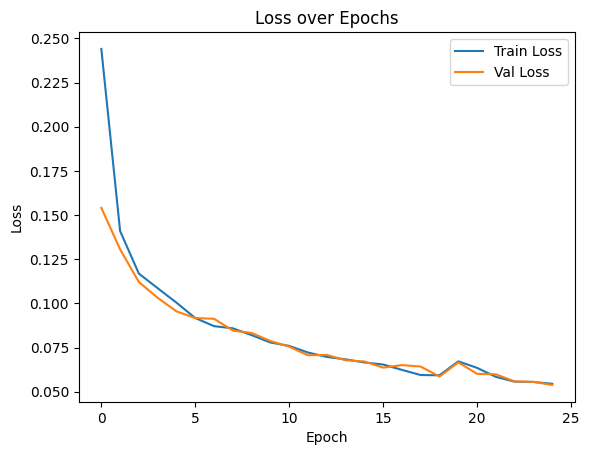

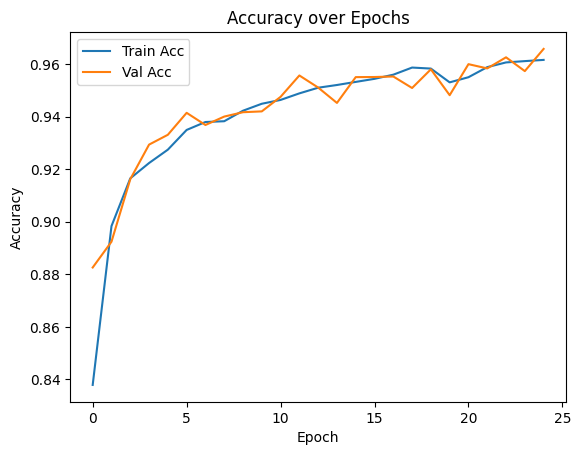

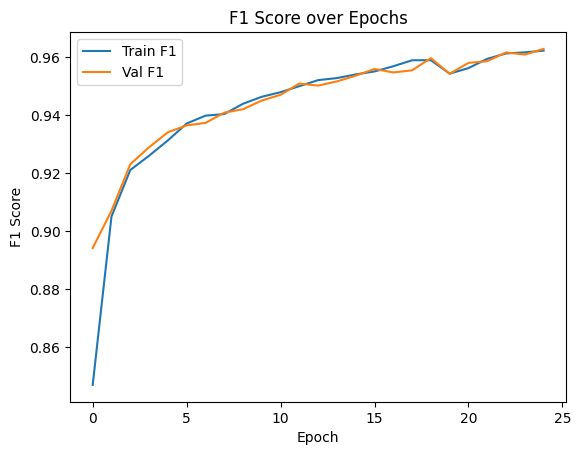

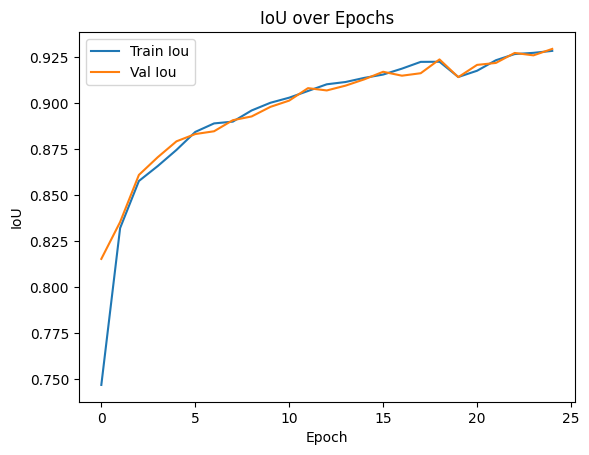

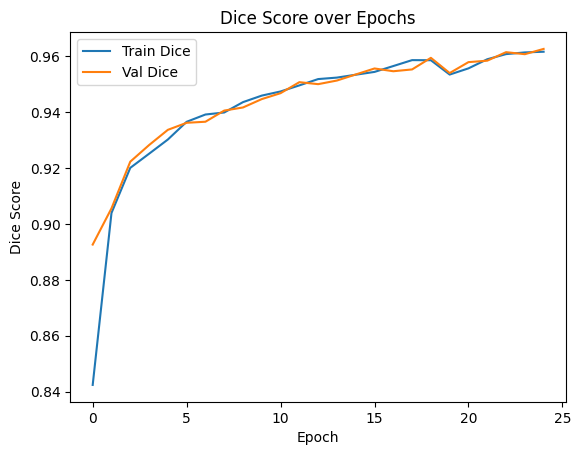

In [ ]:
# Plotting metrics
import matplotlib.pyplot as plt

def plot_metric(name, ylabel):
    plt.figure()
    plt.plot(history[f'train_{name}'], label=f'Train {name.capitalize()}')
    plt.plot(history[f'val_{name}'], label=f'Val {name.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(f'{ylabel} over Epochs')
    plt.show()

plot_metric('loss', 'Loss')
plot_metric('acc', 'Accuracy')
plot_metric('f1', 'F1 Score')
plot_metric('iou', 'IoU')
plot_metric('dice', 'Dice Score')

Running Inference on Test Set: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


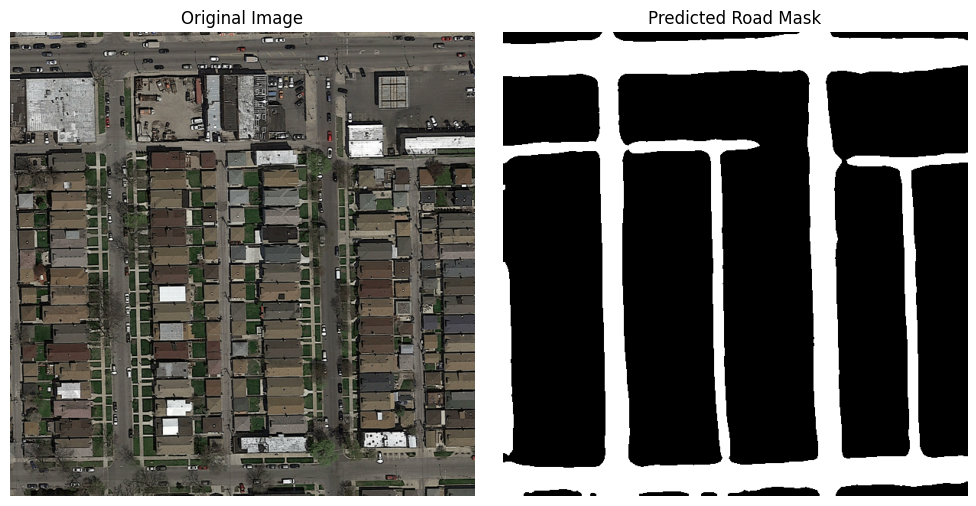

In [ ]:
#Test‐time inference + single‐sample visualization
import os
import cv2
import torch
import torch.nn.functional as F
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the test images directory and the directory to save predictions
TEST_IMAGES_DIR = '/content/drive/MyDrive/Road Segmentation/test_set_images'
PREDICTIONS_DIR = '/content/drive/MyDrive/Road Segmentation/test_predictions'

# Create the predictions directory if it doesn't exist
os.makedirs(PREDICTIONS_DIR, exist_ok=True)

# Ensure the model is in evaluation mode
model.eval()

# Get all image paths from the test directory and its subdirectories
test_image_paths = sorted(glob(os.path.join(TEST_IMAGES_DIR, '**', '*.*'), recursive=True))

# Loop through each test image and save mask
for img_path in tqdm(test_image_paths, desc="Running Inference on Test Set"):
    # Read and preprocess the image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Failed to read image: {img_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w, _ = image.shape

    # Apply the same validation transforms you used during training
    augmented = val_transform(image=image)
    input_tensor = augmented["image"].unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        logits = model(pixel_values=input_tensor).logits
        logits = F.interpolate(logits, size=(orig_h, orig_w),
                               mode='bilinear', align_corners=False)
        prediction = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

    # Convert the prediction to a binary mask (0 background, 255 road)
    prediction_mask = (prediction * 255).astype(np.uint8)

    # Save the prediction mask (same filename as input)
    base_filename = os.path.basename(img_path)
    save_path = os.path.join(PREDICTIONS_DIR, base_filename)
    cv2.imwrite(save_path, prediction_mask)

# Visualize one example

# Pick one sample (e.g. the first)
sample_img_path  = test_image_paths[0]
sample_mask_path = os.path.join(PREDICTIONS_DIR, os.path.basename(sample_img_path))

# Load original image and the saved mask
orig = cv2.imread(sample_img_path)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)

# Plot them side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(orig)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Predicted Road Mask")
plt.axis("off")

plt.tight_layout()
plt.show()
